# 基于第二次世界大战天气状况的探索性数据分析与预测-part1-数据探索

## 任务目的

对二战中的空袭行动与天气状况数据进行分析，基于第二次世界大战中的空中轰炸行动和天气状况的多种数据源，利用 EDA (Exploratory Data Analysis)分析数据并对数据进行清理，根据时间序列预测方式，预测出轰炸目标城市、天气状况以及行动何时完成等。

## 任务内容

- 下载数据集
- 数据清洗
- 数据可视化
  - 袭击了多少个国家
  - 主要目标国家
  - 十大飞机系列
  - 起飞基地位置（攻击国家）
  - 目标位置
  - 轰炸路径
  - 战区
  - 气象站位置
- 基于 ARIMA 的时间序列预测
  - 时间序列的季节性趋势
  - 检查时间序列的平稳性
  - 避免趋势性和季节性的方法
  - 预测时间序列
  - 使用（1,0,1）作为 ARIMA 模型的参数并预测
  - 预测和可视化所有路径并查找均方误差


### 数据清洗

- EDA: Exploratory Data Analysis
- 空袭数据包含了大量的 NaN 值。项目中没有使用它们，而是删除了一些 NaN 值。它不仅消除了不确定性，而且是一个可视化的过程。
  - 删除值为 NaN 的国家
  - 如果目标经度为 NaN，则删除
  - 起飞经度为 NaN 时删除
  - 删除未使用的特征
- 天气状况数据不需要任何清理。通过对勘探数据的分析和可视化，选择一定的地点进行深入研究。只放入使用的数据变量。


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import chart_studio.plotly as py
from plotly.offline import init_notebook_mode, iplot

init_notebook_mode(connected=True)

import plotly.graph_objs as go

# plt.style.use("ggplot")

import warnings

warnings.filterwarnings("ignore")

In [ ]:
import os
import sys

data_path = "./data"
print(os.listdir(data_path))

# 二战中的空中轰炸行动（Aerial Bombing Operations in WW2）
# 这一数据包括轰炸行动。例如，1945 年，美国使用庞特奥利沃机场炸弹德国（柏林）和A36 飞机。
aerial_path = os.path.join(data_path, "operations.csv")

# 二战期间的天气状况（Wether Conditions in WW2）
# 二战期间的天气状况。例如，根据乔治镇气象站，1942 年 1 月 7 日的平均气温是 23.88 度。该数据集中有 2 个子集：
# 第一个包括气象站的位置，如国家、纬度和经度。
weather_station_location_path = os.path.join(data_path, "Weather Station Locations.csv")
# 第二个包括气象站的测量最低、最高和平均温度。
weather_path = os.path.join(data_path, "Summary of Weather.csv")

In [ ]:
aerial = pd.read_csv(aerial_path)
weather_station_location = pd.read_csv(weather_station_location_path)
weather = pd.read_csv(weather_path)

In [ ]:
# Exploratory Data Analysis
aerial.head()
aerial.describe()
aerial.info()

weather_station_location.head()
weather_station_location.info()

weather.head()
weather.info()

In [ ]:
# Data Cleaning: aerial

# drop countries that are NaN
aerial = aerial[pd.isna(aerial.Country) == False]
# drop if target longitude is NaN
aerial = aerial[pd.isna(aerial["Target Longitude"]) == False]
# Drop if takeoff longitude is NaN
aerial = aerial[pd.isna(aerial["Takeoff Longitude"]) == False]
# drop unused features
drop_list = [
    "Mission ID",
    "Unit ID",
    "Target ID",
    "Altitude (Hundreds of Feet)",
    "Airborne Aircraft",
    "Attacking Aircraft",
    "Bombing Aircraft",
    "Aircraft Returned",
    "Aircraft Failed",
    "Aircraft Damaged",
    "Aircraft Lost",
    "High Explosives",
    "High Explosives Type",
    "Mission Type",
    "High Explosives Weight (Pounds)",
    "High Explosives Weight (Tons)",
    "Incendiary Devices",
    "Incendiary Devices Type",
    "Incendiary Devices Weight (Pounds)",
    "Incendiary Devices Weight (Tons)",
    "Fragmentation Devices",
    "Fragmentation Devices Type",
    "Fragmentation Devices Weight (Pounds)",
    "Fragmentation Devices Weight (Tons)",
    "Total Weight (Pounds)",
    "Total Weight (Tons)",
    "Time Over Target",
    "Bomb Damage Assessment",
    "Source ID",
]
aerial.drop(drop_list, axis=1, inplace=True)
aerial = aerial[aerial.iloc[:, 8] != "4248"]  # drop this takeoff latitude
aerial = aerial[aerial.iloc[:, 9] != 1355]  # drop this takeoff longitude

In [ ]:
aerial.describe()
aerial.head()
aerial.info()

In [ ]:
# Data Cleaning: weather locations
# what we will use only
weather_station_location = weather_station_location.loc[
    :, ["WBAN", "NAME", "STATE/COUNTRY ID", "Latitude", "Longitude"]
]
weather_station_location.info()

In [ ]:
# Data Cleaning: weather
# what we will use only
weather = weather.loc[:, ["STA", "Date", "MeanTemp"]]
weather.info()

### 数据可视化

- 袭击了多少个国家
- 主要目标国家
- 十大飞机系列
- 起飞基地位置（攻击国家）
- 目标位置
- 轰炸路径
- 战区
- 气象站位置


In [ ]:
# country: 袭击了多少个国家
print(aerial["Country"].value_counts())
plt.figure(figsize=(22, 10))
sns.countplot(aerial["Country"])
plt.show()

In [ ]:
# Top target countries: 主要目标国家
print(aerial["Target Country"].value_counts()[:10])
plt.figure(figsize=(22, 10))
sns.countplot(aerial["Target Country"])
plt.xticks(rotation=90)
plt.show()

In [ ]:
# nbformat
# This package contains the base implementation of the Jupyter Notebook format,
# and Python APIs for working with notebooks.

# Aircraft Series: 十大飞机系列
data = aerial["Aircraft Series"].value_counts()
print(data[:10])
data = [
    go.Bar(
        x=data[:10].index,
        y=data[:10].values,
        hoverinfo="text",
        marker=dict(
            color="rgba(177, 14, 22, 0.5)", line=dict(color="rgb(0,0,0)", width=1.5)
        ),
    )
]

layout = dict(
    title="Aircraft Series",
)
fig = go.Figure(data=data, layout=layout)
iplot(fig)

In [ ]:
aerial["Target Country"].unique()

array(['ITALY', 'SOLOMON ISLANDS', 'GREECE', 'CRETE', nan,
       'PHILIPPINE ISLANDS', 'BISMARK ARCHIPELAGO', 'GERMANY', 'LIBYA',
       'ERITREA', 'ETHIOPIA', 'SUDAN', 'BOUGAINVILLE', 'SOMALIA',
       'SICILY', 'THAILAND OR SIAM', 'NETHERLANDS EAST INDIES',
       'MALAY STATES', 'INDONESIA', 'BURMA', 'BALI', 'ANDAMAN ISLANDS',
       'INDIAN OCEAN', 'JAPAN', 'ROMANIA', 'CHINA', 'EGYPT',
       'FRENCH INDO CHINA', 'TUNISIA', 'FORMOSA AND RYUKYU ISLANDS',
       'NEW GUINEA', 'GILBERT ISLANDS', 'FRANCE', 'PANTELLARIA',
       'SARDINIA', 'MARSHALL ISLANDS'], dtype=object)

In [ ]:
# ATTACK: 起飞基地位置（攻击国家）
aerial["color"] = ""
aerial.color[aerial.Country == "USA"] = "rgb(0,116,217)"
aerial.color[aerial.Country == "GREAT BRITAIN"] = "rgb(255,65,54)"
aerial.color[aerial.Country == "NEW ZEALAND"] = "rgb(133,20,75)"
aerial.color[aerial.Country == "SOUTH AFRICA"] = "rgb(255,133,27)"

data = [
    dict(
        type="scattergeo",
        lon=aerial["Takeoff Longitude"],
        lat=aerial["Takeoff Latitude"],
        hoverinfo="text",
        text="Country: "
        + aerial.Country
        + " Takeoff Location: "
        + aerial["Takeoff Location"]
        + " Takeoff Base: "
        + aerial["Takeoff Base"],
        mode="markers",
        marker=dict(
            sizemode="area",
            sizeref=1,
            size=10,
            line=dict(width=1, color="white"),
            color=aerial["color"],
            opacity=0.7,
        ),
    )
]

layout = dict(
    title="Countries Take Off Bases ",
    hovermode="closest",
    geo=dict(
        showframe=False,
        showland=True,
        showcoastlines=True,
        showcountries=True,
        countrywidth=1,
        projection=dict(type="mercator"),  # mercator: 墨卡托投影
        landcolor="rgb(217, 217, 217)",
        subunitwidth=1,
        showlakes=True,
        lakecolor="rgb(255, 255, 255)",
        countrycolor="rgb(5, 5, 5)",
    ),
)
fig = go.Figure(data=data, layout=layout)
iplot(fig)

In [ ]:
# Bombing paths: 轰炸路径
# trace1
airports = [
    dict(
        type="scattergeo",
        lon=aerial["Takeoff Longitude"],
        lat=aerial["Takeoff Latitude"],
        hoverinfo="text",
        text="Country: "
        + aerial.Country
        + " Takeoff Location: "
        + aerial["Takeoff Location"]
        + " Takeoff Base: "
        + aerial["Takeoff Base"],
        mode="markers",
        marker=dict(size=5, color=aerial["color"], line=dict(width=1, color="white")),
    )
]

# trace2
targets = [
    dict(
        type="scattergeo",
        lon=aerial["Target Longitude"],
        lat=aerial["Target Latitude"],
        hoverinfo="text",
        text="Target Country: "
        + aerial["Target Country"]
        + " Target City: "
        + aerial["Target City"],
        mode="markers",
        marker=dict(size=1, color="red", line=dict(width=0.5, color="red")),
    )
]

# trace3
flight_paths = []
for i in range(len(aerial["Target Longitude"])):
    flight_paths.append(
        dict(
            type="scattergeo",
            lon=[aerial.iloc[i, 9], aerial.iloc[i, 16]],
            lat=[aerial.iloc[i, 8], aerial.iloc[i, 15]],
            mode="lines",
            line=dict(
                width=0.7,
                color="black",
            ),
            opacity=0.6,
        )
    )

layout = dict(
    title="Bombing Paths from Attacker Country to Target ",
    hovermode="closest",
    geo=dict(
        showframe=False,
        showland=True,
        showcoastlines=True,
        showcountries=True,
        countrywidth=1,
        projection=dict(type="mercator"),
        landcolor="rgb(217, 217, 217)",
        subunitwidth=1,
        showlakes=True,
        lakecolor="rgb(255, 255, 255)",
        countrycolor="rgb(5, 5, 5)",
    ),
)

fig = dict(data=flight_paths + airports + targets, layout=layout)
iplot(fig)

In [ ]:
# Theater of Operations: 战区
print(aerial["Theater of Operations"].value_counts())
plt.figure(figsize=(22, 10))
sns.countplot(aerial["Theater of Operations"])
plt.show()

In [ ]:
# weather station locations: 气象站位置

data = [
    dict(
        type="scattergeo",
        lon=weather_station_location.Longitude,
        lat=weather_station_location.Latitude,
        hoverinfo="text",
        text="Name: "
        + weather_station_location.NAME
        + " Country: "
        + weather_station_location["STATE/COUNTRY ID"],
        mode="markers",
        marker=dict(
            sizemode="area",
            sizeref=1,
            size=8,
            line=dict(width=1, color="white"),
            color="blue",
            opacity=0.7,
        ),
    )
]
layout = dict(
    title="Weather Station Locations ",
    hovermode="closest",
    geo=dict(
        showframe=False,
        showland=True,
        showcoastlines=True,
        showcountries=True,
        countrywidth=1,
        projection=dict(type="mercator"),
        landcolor="rgb(217, 217, 217)",
        subunitwidth=1,
        showlakes=True,
        lakecolor="rgb(255, 255, 255)",
        countrycolor="rgb(5, 5, 5)",
    ),
)
fig = go.Figure(data=data, layout=layout)
iplot(fig)

聚焦美缅战争:

- 在这场战争中，美国从 1942 年到 1945 年轰炸了缅甸（卡萨市）。
- 距离这场战争最近的气象站是宾杜库里，它有 1943 年至 1945 年的气温记录。

从 1943 年到 1945 年进行了温度测量。

- 温度在 12 到 32 度之间。
- 冬季的温度比夏季的温度低。


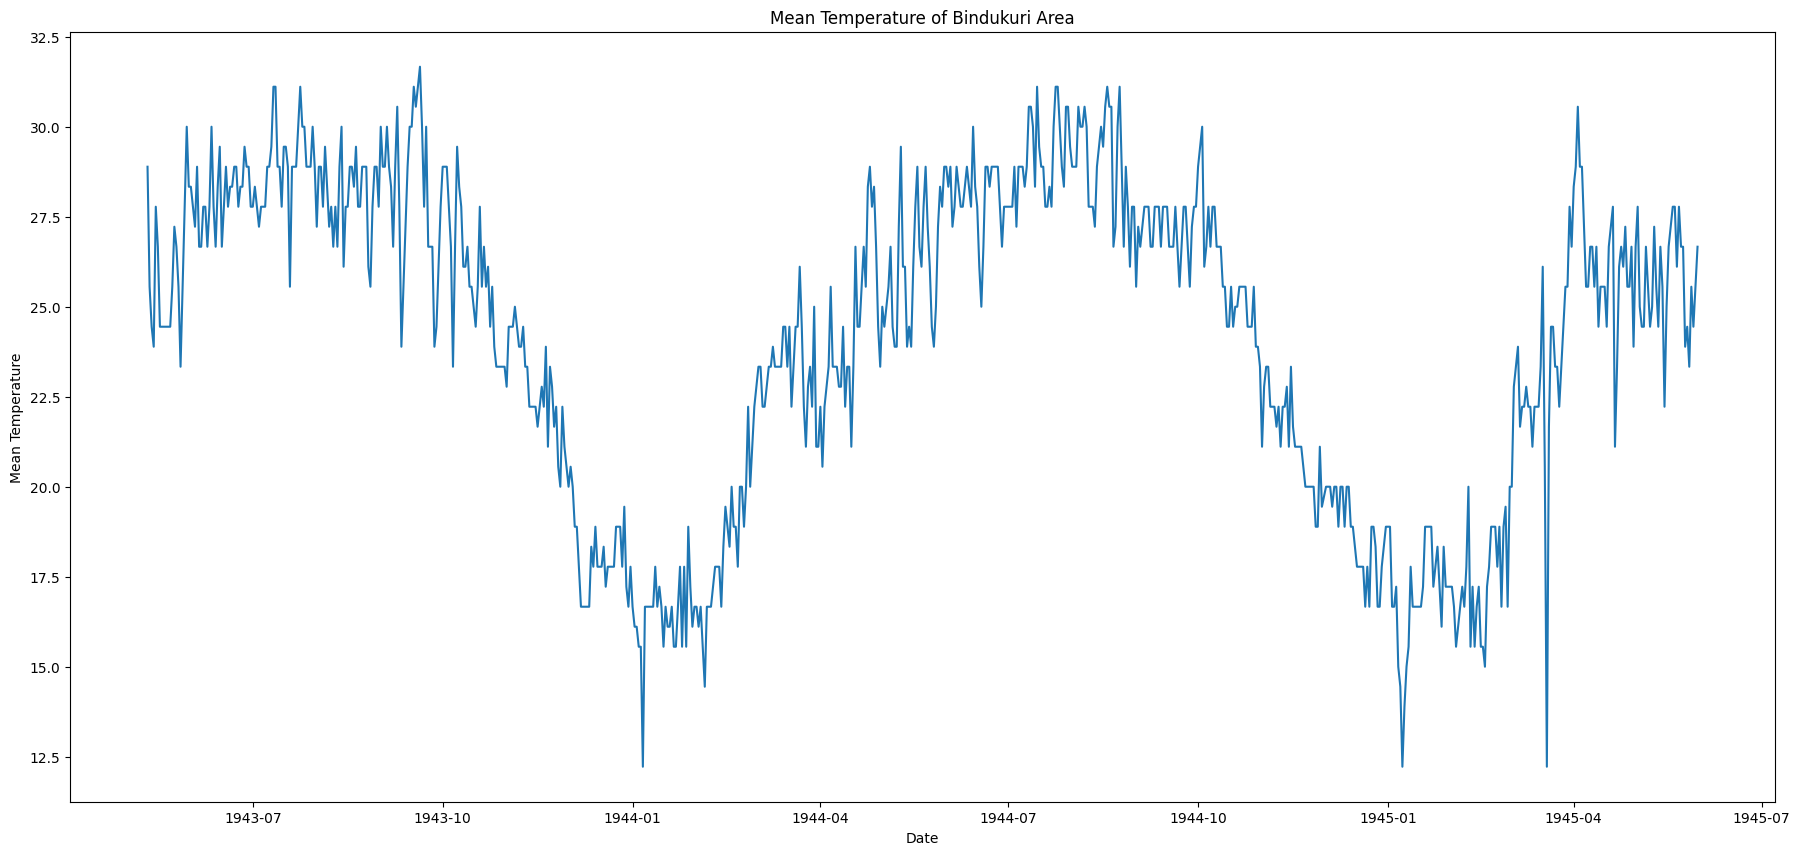

In [19]:
weather_station_id = weather_station_location[
    weather_station_location.NAME == "BINDUKURI"
].WBAN
weather_bin = weather[weather.STA == 32907]
weather_bin["Date"] = pd.to_datetime(weather_bin["Date"])
plt.figure(figsize=(22, 10))
plt.plot(weather_bin.Date, weather_bin.MeanTemp)
plt.title("Mean Temperature of Bindukuri Area")
plt.xlabel("Date")
plt.ylabel("Mean Temperature")
plt.show()

In [21]:
aerial = pd.read_csv(aerial_path)
aerial["year"] = [each.split("/")[2] for each in aerial["Mission Date"]]
aerial["month"] = [each.split("/")[0] for each in aerial["Mission Date"]]
aerial = aerial[aerial["year"] >= "1943"]
aerial = aerial[aerial["month"] >= "8"]

aerial["Mission Date"] = pd.to_datetime(aerial["Mission Date"])

attack = "USA"
target = "BURMA"
city = "KATHA"

aerial_war = aerial[aerial.Country == attack]
aerial_war = aerial_war[aerial_war["Target Country"] == target]
aerial_war = aerial_war[aerial_war["Target City"] == city]

In [22]:
# I get very tired while writing this part, so sorry for this dummy code But I guess you got the idea
liste = []
aa = []
for each in aerial_war["Mission Date"]:
    dummy = weather_bin[weather_bin.Date == each]
    liste.append(dummy["MeanTemp"].values)
aerial_war["dene"] = liste
for each in aerial_war.dene.values:
    aa.append(each[0])

# Create a trace
trace = go.Scatter(
    x=weather_bin.Date,
    mode="lines",
    y=weather_bin.MeanTemp,
    marker=dict(color="rgba(16, 112, 2, 0.8)"),
    name="Mean Temperature",
)
trace1 = go.Scatter(
    x=aerial_war["Mission Date"],
    mode="markers",
    y=aa,
    marker=dict(color="rgba(16, 0, 200, 1)"),
    name="Bombing temperature",
)
layout = dict(
    title="Mean Temperature --- Bombing Dates and Mean Temperature at this Date"
)
data = [trace, trace1]

fig = dict(data=data, layout=layout)
iplot(fig)